# Hebbian Learning 



In [6]:
! pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ------ --------------------------------- 1.3/7.8 MB 7.5 MB/s eta 0:00:01
   -------------- ------------------------- 2.9/7.8 MB 7.3 MB/s eta 0:00:01
   ---------------------- ----------------- 4.5/7.8 MB 7.3 MB/s eta 0:00:01
   ------------------------------ --------- 6.0/7.8 MB 7.2 MB/s eta 0:00:01
   ------------------------------------- -- 7.3/7.8 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 7.2 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------- ----- 1.3/1.5 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
  

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Display settings
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

# For reproducibility
rng = np.random.default_rng(42)

# hints: rng.multivariate_normal gives you 2-D gaussians.
#.       quiver let's you plot actual vector arrows.

## Exercise 1 • Sampling inputs & visualisation

For each of the following zero‑mean 2‑D Gaussian input distributions  

$$
\Sigma_1 =
\begin{pmatrix}1 & 0\\0 & 1\end{pmatrix},\quad
\Sigma_2 =
\begin{pmatrix}1 & 0.4\\0.4 & 1\end{pmatrix},\quad
\Sigma_3 =
\begin{pmatrix}1 & 0.9\\0.9 & 1\end{pmatrix}
$$

1. Draw **500 samples** and show them in a single scatter plot (use different colours/markers).  
2. Draw one random **weight vector** $\mathbf w\in\mathbb R^2$ from a standard normal distribution and add it to the scatter plot.  
3. In a *second* panel visualise the linear activation  
$$
v = \mathbf w\cdot\mathbf u
$$
on a 2‑D grid covering $[-3,3]\times[-3,3]$ using a heatmap, together with the weight vector.


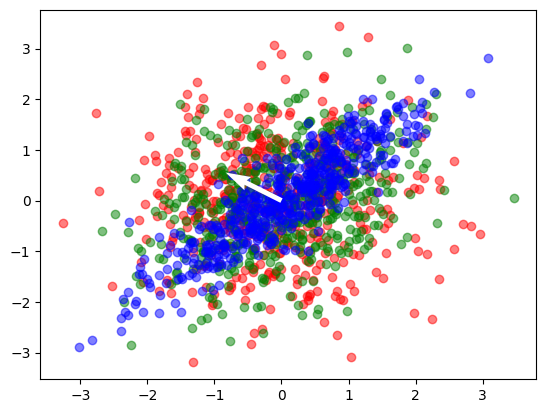

In [18]:
# hints: rng.multivariate_normal gives you 2-D gaussians.
#        quiver let's you plot actual vector arrows.


# save your samples for plotting later: dataset[1], dataset[2], dataset[3]


sample_amount = 500

cov1 = [[1, 0], [0, 1]]
cov2 = [[1, 0.4], [0.4, 1]]
cov3 = [[1, 0.9], [0.9, 1]]

dataset = []
dataset.append(rng.multivariate_normal([0, 0], cov1, sample_amount))
dataset.append(rng.multivariate_normal([0, 0], cov2, sample_amount))
dataset.append(rng.multivariate_normal([0, 0], cov3, sample_amount))

w = rng.standard_normal(2)
w /= np.linalg.norm(w)  # normalize the vector

def make_scatter_plot(distributions, w):
    colors = ['r', 'g', 'b']

    for i in range(len(distributions)):
        plt.scatter(distributions[i][:, 0], distributions[i][:, 1], color=colors[i], alpha=0.5, label=f'Distribution {i+1}')

    # draw w
    plt.quiver(0,0, w[0], w[1], label="w", color="white", width = 0.01, scale=1, scale_units="xy", angles="xy")

    plt.show()

make_scatter_plot(dataset, w)

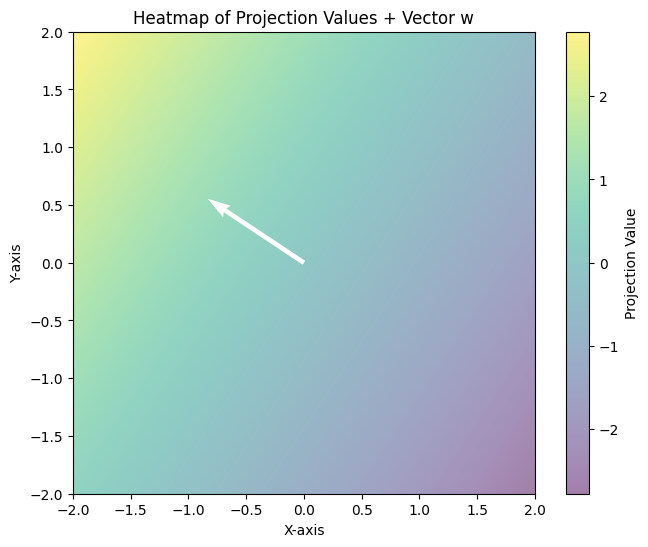

In [25]:
# heatmap

# make 2d grid:
axis = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(axis, axis)

# flatten the grid 
X = X.ravel()
Y = Y.ravel()

U = np.stack([X, Y], axis=1)

V = U @ w 

def make_heatmap(V, w):
    # draw V
    plt.figure(figsize=(8, 6))
    plt.imshow(V.reshape(200, 200), extent=(-2, 2, -2, 2), origin='lower', cmap='viridis', alpha=0.5)
    plt.colorbar(label='Projection Value')
    # draw w
    plt.quiver(0, 0, w[0], w[1], label="w", color="white", width=0.01, scale=1, scale_units="xy", angles="xy")
    # plot things
    plt.title('Heatmap of Projection Values + Vector w')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()
    
make_heatmap(V, w)



## Exercise 2 • Dynamics of Hebbian plasticity

### 2 a — Simple Hebb rule  
Implement  Hebbian learning

\begin{align*}
\Delta\mathbf w_n &= \eta\,v\,\mathbf u \\
v_n &= \mathbf w_n^\top\mathbf u \\
\mathbf w_{n+1} &= w + \Delta\mathbf w_n
\end{align*}

* Use a learning rate $\eta=10^{-3}$.  
* Start from a different random initial vector $\mathbf w_0$.  
* Update once per randomly drawn input sample (2000 steps should suffice).  
* **Plot** the trajectory of the weight vector on top of the corresponding input scatter
  for **each** of the three input distributions
  (use a marker for every 10 updates to keep the plot readable).

Describe qualitatively what you observe.


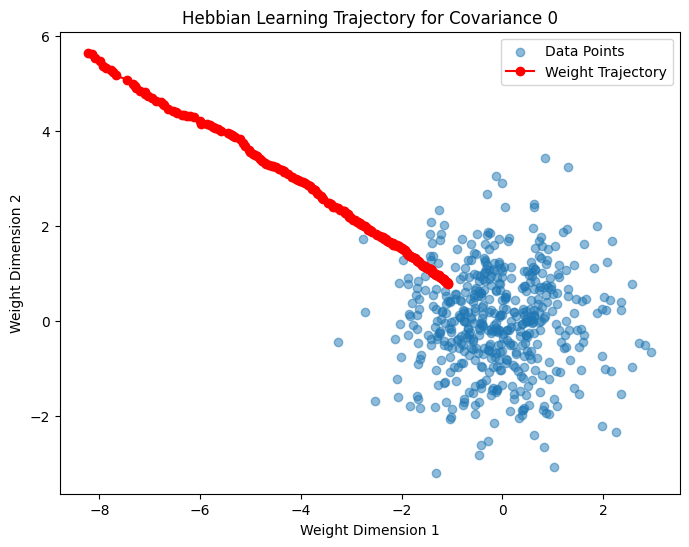

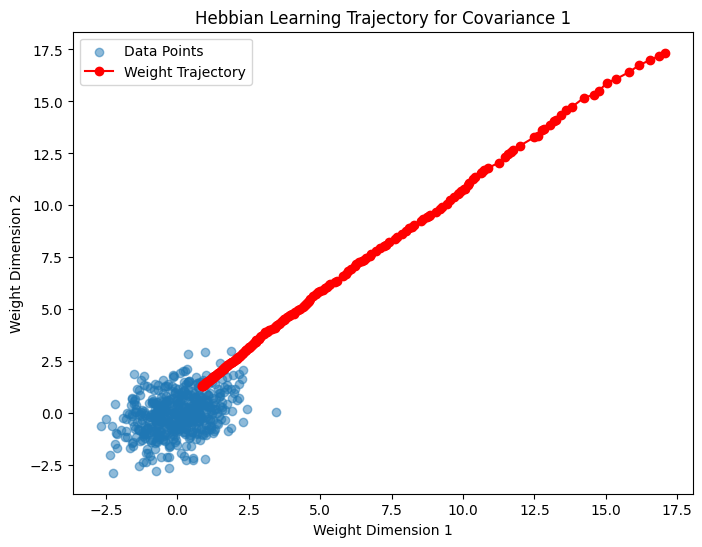

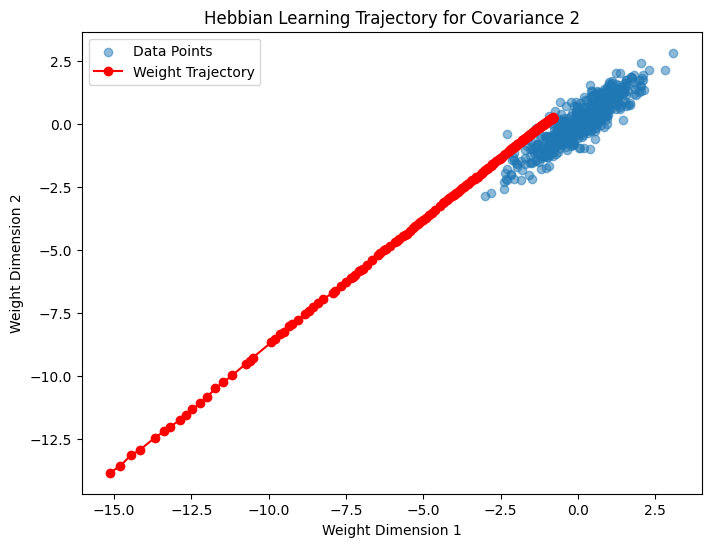

In [58]:
def hebb_update(w, u, lr):
    v = w @ u  # projection of u onto w
    delta_w = lr * v * u
    return delta_w + w


def run_learning(update_fn, cov, w_max=None, lr=1e-3, steps=2000):
    w_initial = rng.standard_normal(2)
    w_traj = [w_initial.copy()]

    for step in range(steps):
        u = rng.multivariate_normal([0, 0], cov)
        if w_max is not None:
            w_new = update_fn(w_traj[-1], u, lr, w_max)
        else:   
            w_new = update_fn(w_traj[-1], u, lr)
        w_traj.append(w_new)

    return np.array(w_traj)


def plot_trajectory(traj, data, title, ax=None):
    decimated_traj = traj[::10]  
    fig, ax = plt.subplots(figsize=(8, 6)) 
    ax.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Data Points')
    ax.plot(decimated_traj[:, 0], decimated_traj[:, 1], marker='o', color='red', label='Weight Trajectory')
    ax.set_title(title)
    ax.set_xlabel('Weight Dimension 1')
    ax.set_ylabel('Weight Dimension 2')
    ax.legend()
    plt.show()
    

# Run Hebbian learning for each covariance matrix
for i, cov in enumerate([cov1, cov2, cov3]):
    traj = run_learning(hebb_update, cov)
    plot_trajectory(traj, dataset[i], f'Hebbian Learning Trajectory for Covariance {i}')

Observation: The weight vector trajectory moves away from the center of the data point distribution, while the orientation keeps getting updated to align (very roughly) with the orientation of the data.

### 2 b — Catch your weight vectors! 
Repeat part (a) but clip the weight vector to a fixed maximum length  
$\lVert\mathbf w\rVert \le w_\max = 2$.

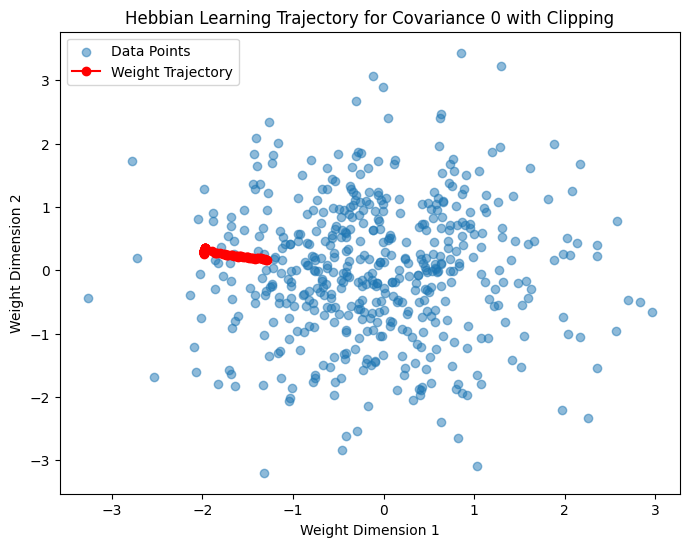

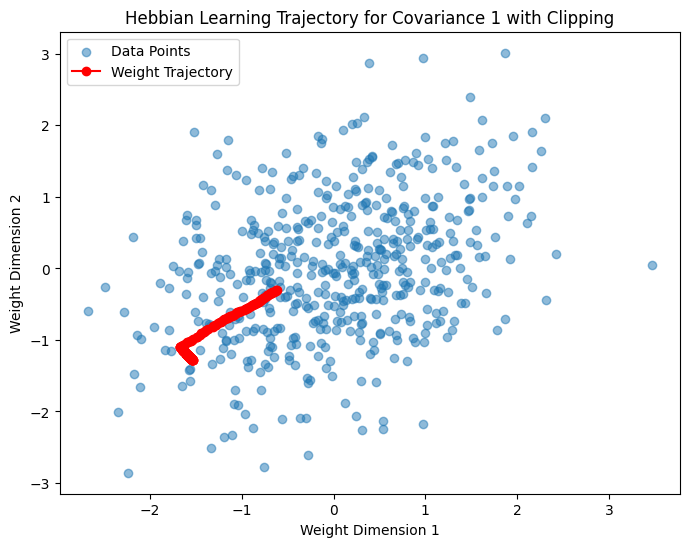

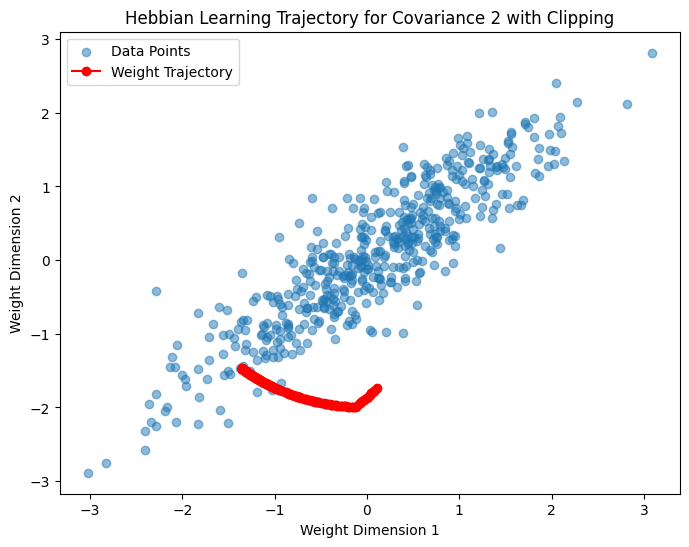

In [65]:
def hebb_clip_update(w, u, lr, w_max):
    v = w @ u  # projection of u onto w
    new_w = lr * v * u + w
    # Clip the weight vector to the maximum norm
    mag = np.sqrt(new_w.dot(new_w))
    if mag > w_max:
        new_w = (new_w / mag) * w_max
    return new_w

w_max = 2.0  # maximum weight value for clipping

# Run Hebbian learning for each covariance matrix
for i, cov in enumerate([cov1, cov2, cov3]):
    traj = run_learning(hebb_clip_update, cov, w_max=w_max)
    plot_trajectory(traj, dataset[i], f'Hebbian Learning Trajectory for Covariance {i} with Clipping')

### 2 c — Oja’s rule  
Implement Oja’s *normalising* rule

$$
\Delta\mathbf w = \eta\bigl(v\,\mathbf u - \alpha\,v^{2}\,\mathbf w\bigr)
$$

with $\alpha=1$.  
Repeat the experiment for each distribution and verify that the norm of \(\mathbf w\) converges.  
Show analytically that at equilibrium  

$$
\bigl\lVert\mathbf w\bigr\rVert = \frac{1}{\sqrt\alpha}.
$$

*(Hint: take the derivative of $\lVert\mathbf w\rVert^{2}$ and set it to zero).*

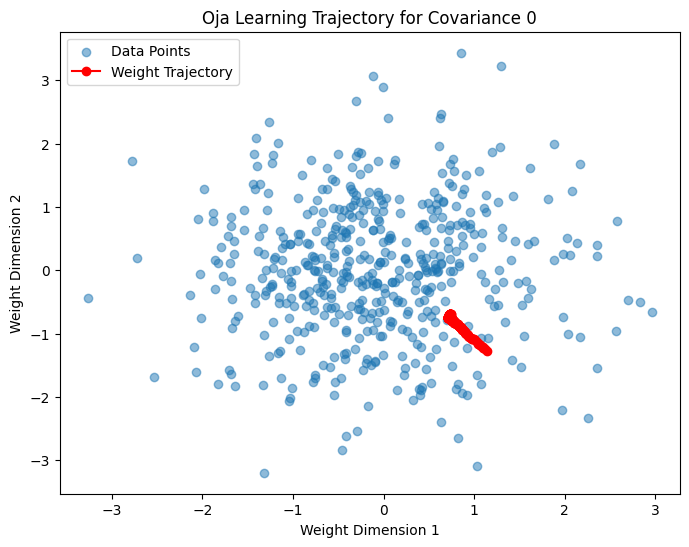

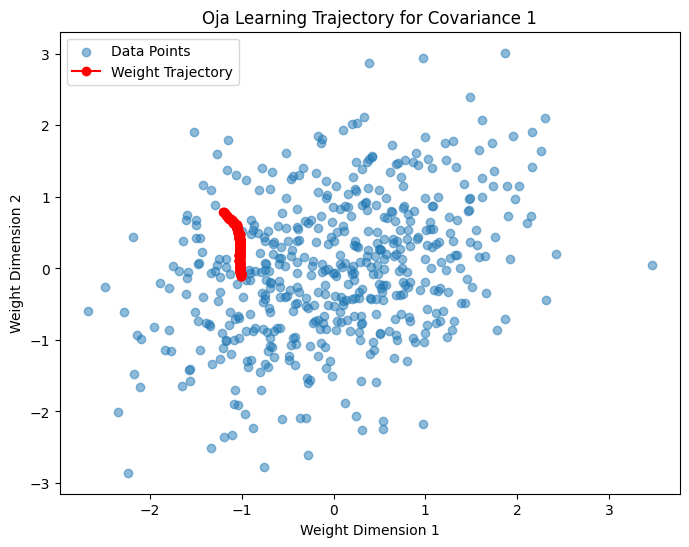

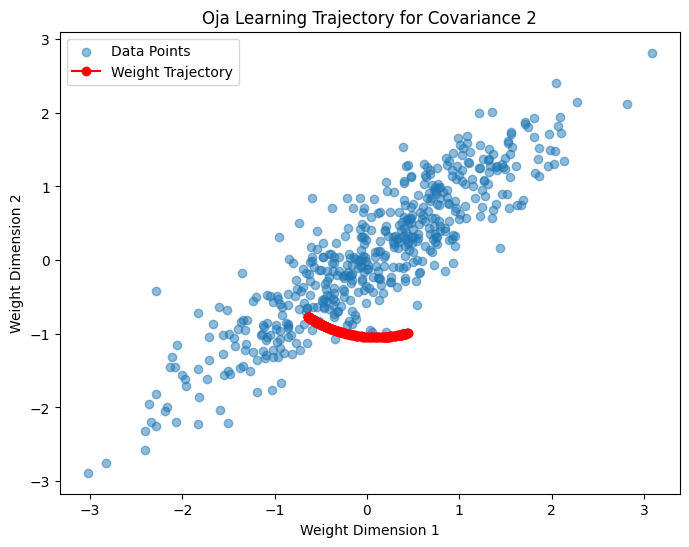

In [97]:
def oja_update(w, u, lr, alpha=1.):
    v = w @ u  
    delta_w = lr * (v * u - alpha * v**2 * w)
    return delta_w + w


final_ws = []
# Run Hebbian learning for each covariance matrix with Oja's rule
for i, cov in enumerate([cov1, cov2, cov3]):
    traj = run_learning(oja_update, cov)
    plot_trajectory(traj, dataset[i], f'Oja Learning Trajectory for Covariance {i}')
    final_ws.append(traj[-1])


<!-- Given Oja’s rule

$$\Delta \mathbf w = \eta (v\mathbf u - \alpha v^2 \mathbf w)$$  

with $v=\mathbf w^\top \mathbf u$ we compute  

\begin{align*}
\Delta \lVert\mathbf w\rVert^2 &= 2\mathbf w^\top \Delta\mathbf w \\
&= 2\eta\left(v^2 - \alpha v^2 \lVert\mathbf w\rVert^2\right) \\
&= 2\eta v^2 \bigl(1-\alpha\lVert\mathbf w\rVert^2\bigr)
\end{align*}  
This rule has an equilibrium (no change) at $\Delta \lVert\mathbf w\rVert^2=0$ and $v^2\neq0$, hence $  \bigl(1-\alpha\lVert\mathbf w\rVert^2\bigr) = 0$

$$\boxed{\lVert\mathbf w\rVert = \dfrac1{\sqrt\alpha}}.$$ -->

## Exercise 3 • Convergence to the First Principal Component

Using the simulations from Exercise 2, confirm *empirically* that the final weight
vector aligns with the **first principal component** (eigenvector with the
largest eigenvalue) of the input covariance matrix.

1. Compute the covariance matrix of each generated data set and its principal
   eigenvector $\mathbf e_1$.
2. Compute the cosine distance of the final weight vector $\mathbf w_*$ (from
   Oja’s rule) and $\mathbf e_1$.
3. Plot the two vectors in the same figure and report the cosine distnace.

*(A small cosine distance ≈ 0 shows successful convergence.)*


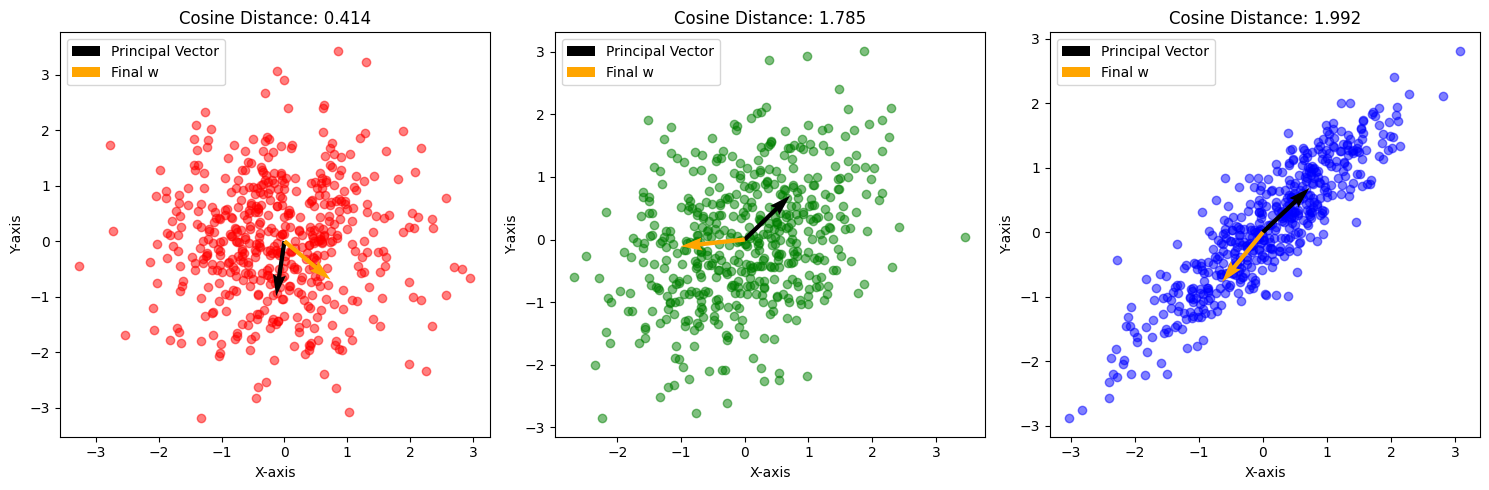

In [98]:

def principal_eigenvector(cov):
    eigvals, eigvecs = np.linalg.eig(cov)
    principal_index = np.argmax(eigvals)
    return eigvecs[:, principal_index]

def cos_dist(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

covariance_matrices = [np.cov(dataset[i], rowvar=False) for i in range(len(dataset))]
principal_vectors = [principal_eigenvector(cov) for cov in covariance_matrices]
cosine_distances = []
for i in range(len(dataset)):
    principal_vector = principal_vectors[i]
    final_w = final_ws[i]
    cosine_distance = cos_dist(principal_vector, final_w)
    cosine_distances.append(cosine_distance)


# plot the cosine distances: plot the vectors (principal and final_w) on top of the distributions
def plot_cosine_distances(distributions, principal_vectors, final_ws):
    colors = ['r', 'g', 'b']
    # do three subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(len(distributions)):
        ax = axs[i]
        ax.scatter(distributions[i][:, 0], distributions[i][:, 1], color=colors[i], alpha=0.5)
        ax.quiver(0, 0, principal_vectors[i][0], principal_vectors[i][1], color='black', label='Principal Vector', width=0.01, scale=1, scale_units='xy', angles='xy')
        ax.quiver(0, 0, final_ws[i][0], final_ws[i][1], color='orange', label='Final w', width=0.01, scale=1, scale_units='xy', angles='xy')
        ax.set_title(f'Cosine Distance: {cosine_distances[i]:.3f}')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.legend()
    plt.tight_layout()
    plt.show()

plot_cosine_distances(dataset, principal_vectors, final_ws)



### Reading Recommendation

Song, S., Miller, K.D. and Abbott, L.F., 2000. Competitive Hebbian learning through spike-timing-dependent synaptic plasticity. Nature neuroscience, 3(9), pp.919-926.